In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin
from networkx.algorithms import bipartite
import sympy as sym
import math as math
import random
from itertools import combinations
import copy
import time

##### Input Graph

Here, we construct the graph for our experiemnt.

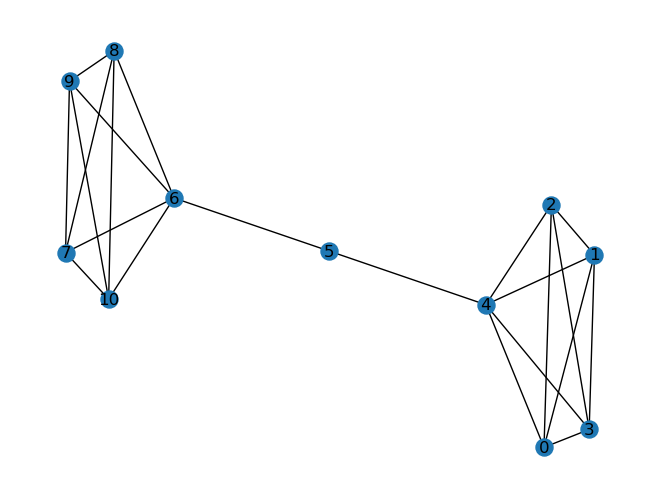

In [2]:
H = nx.barbell_graph(5, 1)

pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=True, node_size=150)

In [3]:
H.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (4, 5), (6, 7), (6, 8), (6, 9), (6, 10), (6, 5), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)])

In [4]:
H.number_of_edges()

22

Constructing a directed graph from an un directed graph.

In [5]:
G = nx.DiGraph()
edges = []
for u, v in H.edges():
    G.add_edge(u, v)
    G.add_edge(v, u)
    edges.append((u, v))
    edges.append((v, u))

In [6]:
out_degrees = {node: G.out_degree(node) for node in G.nodes()}
sorted_nodes = sorted(out_degrees, key=out_degrees.get, reverse=True)

In [7]:
max_degree = max(out_degrees.values())
vertices_with_max_degree = [vertex for vertex, degree in out_degrees.items() if degree == max_degree]
print(vertices_with_max_degree)

[4, 6]


construction of initial state

In [8]:
m_1 = 0
psi_0 = np.matrix(np.zeros((G.number_of_edges(), 1)))
Directed_edges = list(G.edges())
for i in range(len(vertices_with_max_degree)):
    #print(vertices_with_min_degree[i])
    initial_vertex = vertices_with_max_degree[i]
    d = H.degree(initial_vertex)
    E_initial = list(H.neighbors(initial_vertex))
    for vertex in E_initial:
        e = (initial_vertex, vertex)
        a = Directed_edges.index(e)
        psi_0[a] = 1
        m_1 = m_1 + psi_0[a]
        m_1 = m_1
        
psi_0 = psi_0/math.sqrt(m_1)
#psi_0

In [9]:
edge_probability = {}
for edge in G.edges():
    u = edge[0]
    edge_probability[edge] = 1 / out_degrees[u]
# edge_probability

In [10]:
def get_inverse_edge(edge):
    return (edge[1], edge[0])

Construction of Szegedy unitary matrix

In [11]:
edge_list = list(G.edges())
num_edges = len(edge_list)
U = np.zeros((num_edges, num_edges))
for i, e in enumerate(edge_list):
    for j, f in enumerate(edge_list):
        inverse_f = get_inverse_edge(f)
        if e[0] == f[1]:  # origin(e) == terminal(f)
            p_e = edge_probability[e]
            f_1 = get_inverse_edge(f)
            p_f_1 = edge_probability[f_1]
            kronecker_delta = 1 if e == f_1 else 0
            U[i, j] = 2 * np.sqrt(p_e * p_f_1) - kronecker_delta
        else:
            U[i, j] = 0
U = np.matrix(U)
# sym.Matrix(U)

In [12]:
G.edges()

OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (5, 4), (5, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 5), (7, 6), (7, 8), (7, 9), (7, 10), (8, 6), (8, 7), (8, 9), (8, 10), (9, 6), (9, 7), (9, 8), (9, 10), (10, 6), (10, 7), (10, 8), (10, 9)])

Construction edge probability vector 

In [13]:
# Initial setup
psi_list = [psi_0]
probability = []
t = 1
V = U.copy()
psi_1 = psi_0.copy()

p_0 = [a**2 for a in psi_1]
probability.append(p_0)
P_1 = p_0.copy()

# Store probability evolution
prob_evolution = []   # list of P_t
t_values = []         # corresponding t values

error = np.inf

while error > 0.0001:
    psi_2 = V * psi_1  # Using @ for matrix multiplication
    
    p = [a**2 for a in psi_2]
    psi_list.append(psi_2)
    probability.append(p)
    #t = t + 1
    P_2 = [sum(elements) / t for elements in zip(*probability)]
    
    # Store distribution at this t
    prob_evolution.append(P_2.copy())
    t_values.append(t)
    
    P_3 = [a - b for a, b in zip(P_2, P_1)]
    error = np.linalg.norm(P_3)
    psi_1 = psi_2
    V = V * U  # Update V with matrix multiplication
    t = t + 1
    P_1 = P_2.copy()
else:
    edge_list = list(G.edges())
    num_edges = len(edge_list)
    pribability_dictionary = {}
    for i, e in enumerate(edge_list):
        pribability_dictionary[e] = P_1[i].item(0)
#pribability_dictionary 
t

743

In [14]:
Undirected_edges = list(H.edges())
Undirected_pribability = {}
for edge in Undirected_edges:
    a = pribability_dictionary.get(edge,0)
    b = pribability_dictionary.get((edge[1], edge[0]), 0)
    total = a+b
    Undirected_pribability[edge] = total
    #pribability_dictionary[edge] 
# Undirected_pribability

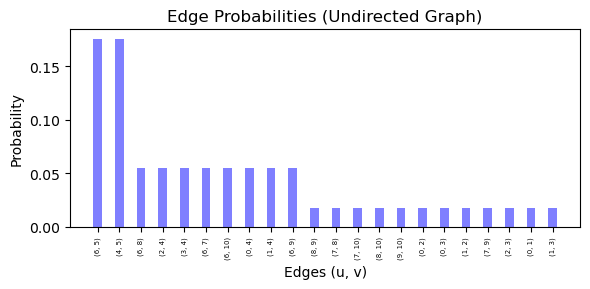

In [15]:
# Prepare data for plotting
edges = [f"({u}, {v})" for (u, v) in Undirected_pribability.keys()]
probs = list(Undirected_pribability.values())

# Sort edges by probability (optional: improves readability)
edges, probs = zip(*sorted(zip(edges, probs), key=lambda x: x[1], reverse=True))

# Plot with thin bars
plt.figure(figsize=(6, 3))  # Smaller figure size
plt.bar(edges, probs, color='blue', width=0.4, alpha=0.5)  # Thin bars
plt.xticks(rotation=90, fontsize=5)
plt.subplots_adjust(bottom=0.35)
plt.xlabel("Edges (u, v)")
plt.ylabel("Probability")
plt.title("Edge Probabilities (Undirected Graph)")
plt.tight_layout()
plt.show()


In [16]:
q = round(1 / (H.number_of_edges()), 4)

Path weight between the vertices

In [17]:
# Define your undirected graph product
network = nx.Graph()

# Add edges with 'prob' attribute to the graph
for (u, v), prob in Undirected_pribability.items():
    network.add_edge(u, v, prob=prob)

# Function to calculate product of probabilities along a path
def path_prob(path):
    edge_probs = []
    for u, v in zip(path[:-1], path[1:]):
        # Since we already stored prob in the graph, use that
        prob = network[u][v]['prob']
        edge_probs.append(prob)
    return math.prod(edge_probs) if edge_probs else None

# Store the path probabilities
average_probs = {}


# Loop through all unique node pairs
for u, v in combinations(network.nodes(), 2):
    if nx.has_path(network, u, v):
        path = nx.shortest_path(network, source=u, target=v)
        prob = path_prob(path)
        average_probs[(u, v)] = prob

# # Print results
# for (u, v), prob in average_probs.items():
#     print(f"Path probability from {u} to {v} (shortest path): {prob:.5f}")

Appilication of community detection procedure (Procedure 3)

In [18]:
hub = sorted_nodes  # list of hubs for plot normalized prob original refinement
same_set = {}
visited = set()
F = set()
communities = {}
main_deg = dict(H.degree())
m_c = 0
normalized_values = {}   # dictionary to store normalized probabilities

for i in hub:
    if i in visited:
        continue  # Skip already processed hubs

    N_i = set(H.neighbors(i))  # Neighbors of hub i
    same_set[i] = {i}  # Start with the hub itself
    visited.add(i)  # Mark hub as visited

    # ===== Expand N_i dynamically =====
    added = True
    while added:
        added = False
        for k in H.nodes():
            if k in visited or k in N_i:
                continue  # Skip already used nodes

            neighbors_k = set(H.neighbors(k))
            if len(neighbors_k & N_i) >= len(neighbors_k) / 2:
                N_i.add(k)
                added = True  # Another round to expand

    # ===== Add nodes based on normalized probability =====
    for j in N_i:
        if j in visited:
            continue  # Skip if already processed
            
        if (i, j) in average_probs:
            normalized_probs = average_probs[(i, j)] / out_degrees[j]
        elif (j, i) in average_probs:
            normalized_probs = average_probs[(j, i)] / out_degrees[j]
        else:
            continue  # Skip if probability not defined
            
        # ✅ NEW line (store normalized probability, doesn’t affect logic)
        normalized_values[(i, j)] = normalized_probs
            
        if normalized_probs < q:
            same_set[i].add(j)

    # ===== Build initial community edges =====
    community_i = set()
    for u, v in H.edges():
        if u in same_set[i] and v in same_set[i]:
            community_i.add((u, v))

    # ===== After refinement =====
    refined_nodes = set()
    subG = H.edge_subgraph(community_i).copy()
    for node in subG.nodes():
        deg_comm = subG.degree(node)
        deg_main = main_deg[node]
        if deg_comm > deg_main / 2:
            refined_nodes.add(node)

    # Keep only edges where both endpoints survived
    refined_edges = {(u, v) for (u, v) in community_i if u in refined_nodes and v in refined_nodes}
    communities[i] = refined_edges
    
    m_c = len(communities[i]) + m_c

    # Mark all refined nodes as visited so they won't appear in next iteration
    visited.update(refined_nodes)

    F.add(i)  # Add hub i to the final set
    print(f"Nodes belonging to the same set as hub {i} after refinement: {refined_nodes}")

Nodes belonging to the same set as hub 4 after refinement: {0, 1, 2, 3, 4}
Nodes belonging to the same set as hub 6 after refinement: {6, 7, 8, 9, 10}
Nodes belonging to the same set as hub 5 after refinement: set()


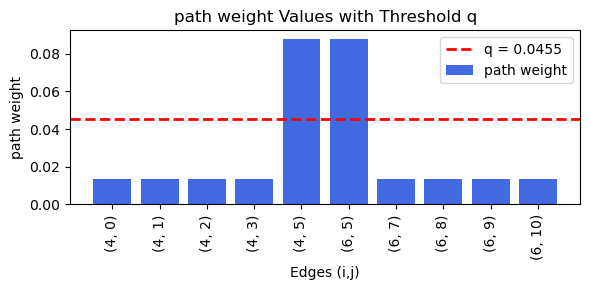

In [19]:
# Prepare data
edges = [f"({i}, {j})" for (i, j) in normalized_values.keys()]
values = list(normalized_values.values())

# # Sort by value for better visualization
# edges, values = zip(*sorted(zip(edges, values), key=lambda x: x[1], reverse=True))

# Plot bars
plt.figure(figsize=(6, 3))
plt.bar(edges, values, color='royalblue', label='path weight')
# plt.figure(figsize=(4, 3))  # Smaller figure size
# plt.bar(edges, probs, width=0.2, alpha=0.5)  # Thin bars


# Plot q line
plt.axhline(y=q, color='red', linestyle='--', linewidth=2, label=f'q = {q}')

# Labels and formatting
plt.xticks(rotation=90)
plt.xlabel("Edges (i,j)")
plt.ylabel("path weight")
plt.title("path weight Values with Threshold q")
plt.legend()
plt.tight_layout()
plt.show()

Display community

In [20]:
# ===== Find unassigned nodes ===== for refinement

# All nodes in the main graph
all_nodes = set(H.nodes())

# Collect all nodes that belong to any non-trivial community
nodes_in_communities = set()
unassigned_hubs = set()

for i in same_set:
    # If the hub has no other node except itself → unassigned hub
    if same_set[i] == {i}:
        unassigned_hubs.add(i)
    else:
        nodes_in_communities.update(same_set[i])

# Unassigned = nodes not in any community + hubs with no other members
unassigned_nodes = (all_nodes - nodes_in_communities).union(unassigned_hubs)

print(f"Unassigned nodes: {unassigned_nodes}")


Unassigned nodes: {5}


4


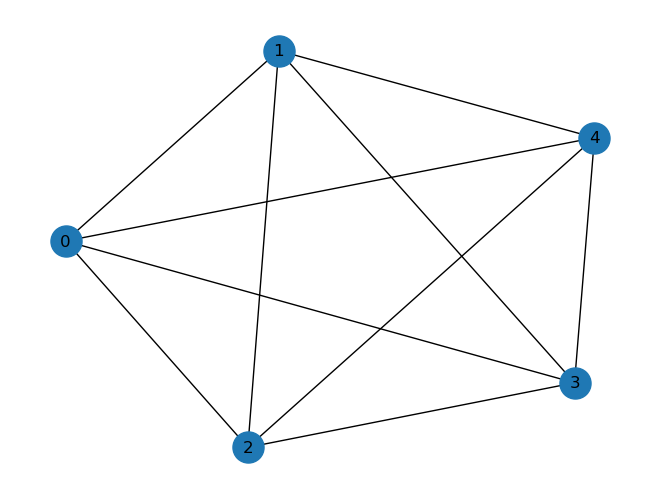

6


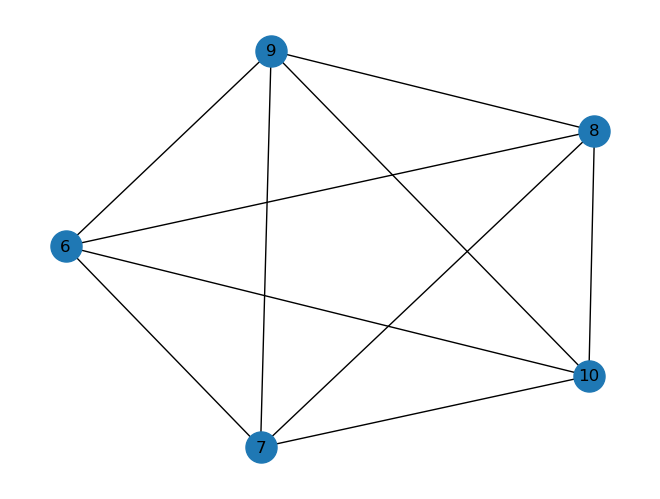

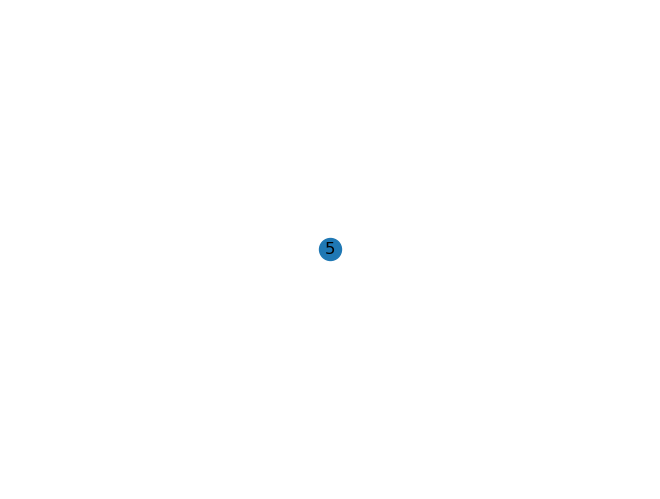

In [21]:
F_1 = set()
for i in F:
    H_i = nx.Graph()
    community_edges = communities.get(i, None)
    if community_edges:
        F_1.add(i)
        print(i)
        H_i.add_edges_from(communities[(i)]) 
        plt.figure()  
        nx.draw(H_i, with_labels=True, node_size=500)
        plt.show()  
        
H_unassigned_nodes = nx.Graph()
unassigned_nodes_dic = list(unassigned_nodes)
H_unassigned_nodes.add_nodes_from(unassigned_nodes_dic)
# H_unassigned_nodes.add_nodes_from(unassigned_nodes_1)
plt.figure()  # Create a new figure
nx.draw(H_unassigned_nodes, with_labels=True, node_size=250)
#plt.title(f'H_unassigned_nodes')  # Title for each graph
plt.show()  # Display the graph

In [22]:
%%time
def find_vertex_set(edge_set):
    vertex_set = set()
    for edge in edge_set:
        vertex_set.update(edge)
    return vertex_set

clusters = []
for i in F_1:
    vertex_set_i = find_vertex_set(communities[i])
    print(vertex_set_i)
    clusters.append(vertex_set_i)

{0, 1, 2, 3, 4}
{6, 7, 8, 9, 10}
CPU times: total: 0 ns
Wall time: 0 ns


Showing communities in the given graph.

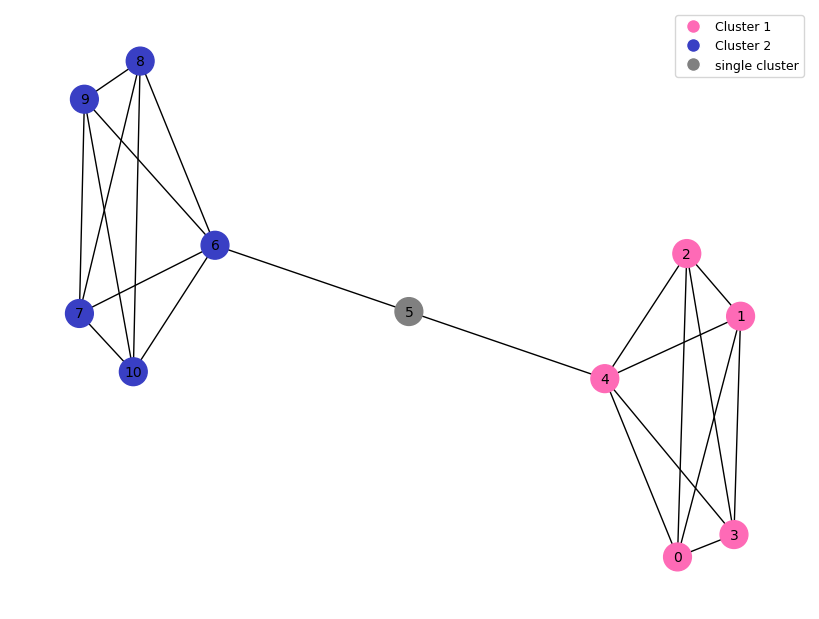

In [23]:
def generate_random_color():
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    while color == {"#000000", "#808080"}:  # Avoid black and gray
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    return color
cluster_colors = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(clusters))]

edges_1 = H.edges
C = nx.Graph()
C.add_edges_from(edges_1)

color_map = [next((color for cluster, color in zip(clusters, cluster_colors) if node in cluster), "gray")for node in C]

# Draw the graph
plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(C)  # Layout for graph visualization

nx.draw(C, pos, with_labels=True, node_color=color_map, node_size=400, edge_color="black", font_size=10)

legend_labels = [f"Cluster {i + 1}" for i in range(len(cluster_colors))]

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
    for color, label in zip(cluster_colors, legend_labels)]

handles.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="gray", markersize=10, label="single cluster"))
plt.legend(handles=handles, loc="best", fontsize=9, frameon=True)

#plt.title("Clustered Graph", fontsize=14)
plt.show()

Coverage

In [24]:
coverage = m_c/len(H.edges)
coverage

0.9090909090909091

Convergence of probability distributions.

In [25]:
target_edges = [(6, 5), (1, 4), (8, 10)]
edge_indices = [edge_list.index(e) for e in target_edges]
selected_t = [1, 10, 15, 25, 35, 50]
edge_prob_selected = {e: [] for e in target_edges}
t_selected = []

for t, P_t in zip(t_values, prob_evolution):
    if t in selected_t:
        t_selected.append(t)
        for e, idx in zip(target_edges, edge_indices):
            edge_prob_selected[e].append(P_t[idx].item())

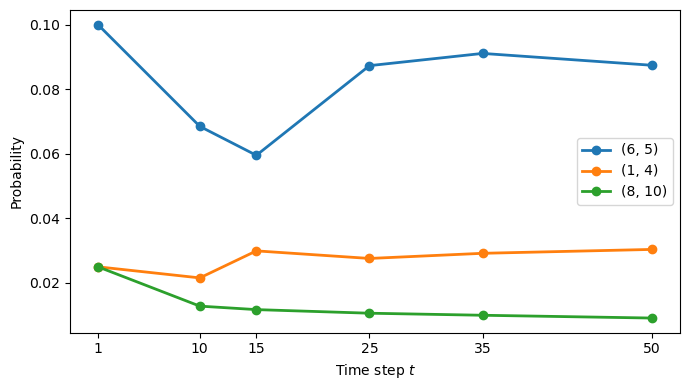

In [26]:
plt.figure(figsize=(7, 4))

for e in target_edges:
    plt.plot(
        t_selected,
        edge_prob_selected[e],
        marker='o',
        linewidth=2,
        label=str(e)
    )

plt.xlabel("Time step $t$")
plt.ylabel("Probability")
# plt.title("Edge probabilities at selected time steps")
plt.legend()
# plt.grid(True)
plt.xticks(t_selected)
plt.tight_layout()
plt.show()
